<a href="https://colab.research.google.com/github/raheemahmedd/ASDC-internship/blob/main/ML(task2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import packages

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import sys
import numpy as np
import scipy.io
import os
from PIL import Image
import cv2
import pickle
import tensorflow as tf
import random

# Data preprocessing

In [ ]:
def preprocess(img):

    resized = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)

    h,w, c = img.shape

    _, thresh = cv2.threshold(img, np.mean(img), 255, cv2.THRESH_BINARY_INV)
    edges = cv2.dilate(cv2.Canny(thresh, 0, 255), None)

    cnt = sorted(cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2], key=cv2.contourArea)[-1]
    mask = np.zeros((h, w), np.uint8)
    masked = cv2.drawContours(mask, [cnt], -1, 255, -1)

    dst = cv2.bitwise_and(img, img, mask=masked)
    segmented = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(segmented, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    #thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, constant)


    return blur


In [ ]:
def VGGpreprocess(img):

    resized = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)

    h,w, c = img.shape

    _, thresh = cv2.threshold(img, np.mean(img), 255, cv2.THRESH_BINARY_INV)
    edges = cv2.dilate(cv2.Canny(thresh, 0, 255), None)

    cnt = sorted(cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2], key=cv2.contourArea)[-1]
    mask = np.zeros((h, w), np.uint8)
    masked = cv2.drawContours(mask, [cnt], -1, 255, -1)

    dst = cv2.bitwise_and(img, img, mask=masked)
    segmented = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    #gray = cv2.cvtColor(segmented, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(segmented, (3, 3), 0)
    #thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, constant)


    return blur


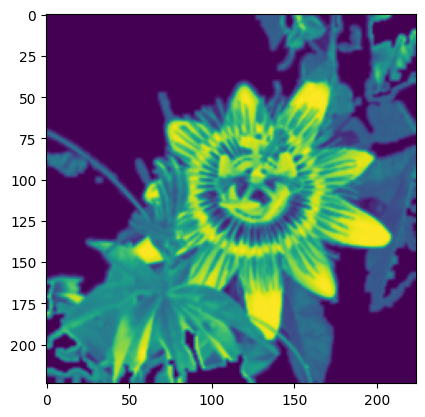

In [ ]:
sample_directory="/content/drive/MyDrive/oxford-102-flower-pytorch//flower_data//flower_data//test//image_00005.jpg"
block_size = 3
constant = 1.5
path = os.path.join(f"{sample_directory}")
img_array = cv2.imread(os.path.join(path))
#gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
#blur = cv2.GaussianBlur(gray, (3, 3), 0)
#thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, constant)

plt.imshow(preprocess(img_array))
plt.show()

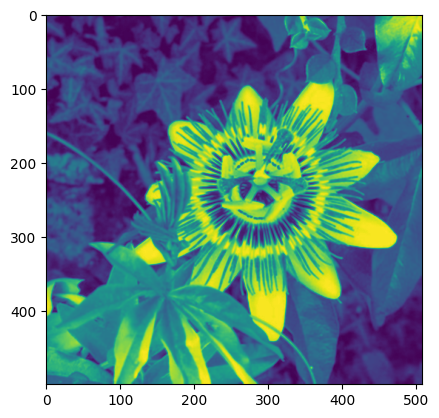

In [ ]:
sample_directory="/content/drive/MyDrive/oxford-102-flower-pytorch//flower_data//flower_data//test//image_00005.jpg"
block_size = 3
constant = 1.5
path = os.path.join(f"{sample_directory}")
img_array = cv2.imread(os.path.join(path))
gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (3, 3), 0)
#thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, constant)

plt.imshow(blur)
plt.show()

# Load Datasets

In [ ]:
train_data=[]

valid_data=[]

directory="/content/drive/MyDrive/oxford-102-flower-pytorch//flower_data//flower_data"
for folder in os.listdir(directory):
    if folder =="test":
        pass
    for files in os.listdir(f"{directory}/{folder}"):
        for img in os.listdir(f"{directory}/{folder}/{files}"):
            img_array = cv2.imread(os.path.join(f"{directory}/{folder}/{files}/{img}"))
            img_array=preprocess(img_array)
            #plt.imshow(img_array)
            if folder=="train":
                train_data.append([img_array, files])
            elif folder=="valid":

                valid_data.append([img_array, files])

In [ ]:
plt.imshow(train_data[0][0])

In [ ]:
with open('train.pkl','wb') as f:
      pickle.dump(train_data, f)

In [ ]:
with open('valid.pkl','wb') as f:
      pickle.dump(valid_data, f)

In [ ]:
with open('/content/drive/MyDrive/train.pkl','rb') as f:
       x = pickle.load(f)


In [ ]:
np_train_data =np.array(train_data,dtype=object)

#train_data=np.array(x)

# Random Shuffle

In [ ]:
random.shuffle(np_train_data)

In [ ]:
X =[]
y =[]
for features, label in np_train_data:
    X.append(features)
    y.append(label)
#A 2D array can be reshaped into a 1D array using .reshape(-1).
X = np.array(X).reshape(-1, 224, 224, 1)
y=np.array(y)
X.shape,y.shape

# Normalising X and converting labels to categorical data

In [ ]:
X = X.astype('float32')
X /= 255
y=y.astype('int')

# Define, compile and train the CNN Model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(103, activation=tf.nn.softmax)
])
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X, y, batch_size=128, epochs=20, validation_split = 0.2)

In [ ]:
# from keras.applications.vgg16 import VGG16
# from keras.preprocessing import image
# from keras.applications.vgg16 import preprocess_input

# model = VGG16(weights='imagenet', include_top=False)

In [ ]:
# train_features = model.predict(X)
# #test_features = model.predict(X_test)

In [ ]:
# from tensorflow.keras.applications.vgg16 import VGG16

# base_model = VGG16(input_shape = (224, 224, 1), # Shape of our images
# include_top = False, # Leave out the last fully connected layer
# weights = 'imagenet')

In [ ]:
test_directory="D://ASDC//task-two-ml//oxford-102-flower-pytorch//flower_data//flower_data//test"
test_data=[]
for img in os.listdir(test_directory):
    path = os.path.join(f"{test_directory}/{img}")
    img_array = cv2.imread(os.path.join(path))
    preprocess(img_array)
    test_data.append(img_array)
#     plt.imshow(img_array)
#     plt.show()
#     break